In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=3284c493e32c8949d6b50b6e24d6f3fc8d7459f668671e27b0d996da37933705
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
import warnings
warnings.simplefilter("ignore")

# offer 별 complete 요인 결정


In [18]:
data = pd.read_csv('starbucks.csv',index_col=0 )
# email변수는 전부 1이라서, 분석이 무의미하므로 미리 제거
data.drop('email', axis=1, inplace = True)
data.head()

,event,time,offer_id,gender,age,income,member_year,member_month,member_day,members_since_in_days,member_since_year,reward,difficulty,duration,offer_type,web,mobile,social,customer_ids
0,offer received,0,6,0,75,100000,2017,5,9,1646,4,5,5,7,0,1,1,0,1
1,offer viewed,6,6,0,75,100000,2017,5,9,1646,4,5,5,7,0,1,1,0,1
2,offer completed,132,6,0,75,100000,2017,5,9,1646,4,5,5,7,0,1,1,0,1
3,offer received,168,5,0,75,100000,2017,5,9,1646,4,0,0,3,2,0,1,1,1
4,offer viewed,216,5,0,75,100000,2017,5,9,1646,4,0,0,3,2,0,1,1,1


### NA
없음

In [19]:
#na 데이터는 없음
data.isnull().sum()

event                    0
time                     0
offer_id                 0
gender                   0
age                      0
income                   0
member_year              0
member_month             0
member_day               0
members_since_in_days    0
member_since_year        0
reward                   0
difficulty               0
duration                 0
offer_type               0
web                      0
mobile                   0
social                   0
customer_ids             0
dtype: int64

### corr
멤버쉽 가입 날짜끼리 높은 상관관계를 가짐을 확인했습니다. 제 분석목적에 있어서, 구지 여러 변수를 모두 포함할 이유는 없을것 같아, 상관관계도 높게 나온 만큼 members_since_in_days 제외하고는 모두 삭제하기로 했습니다.

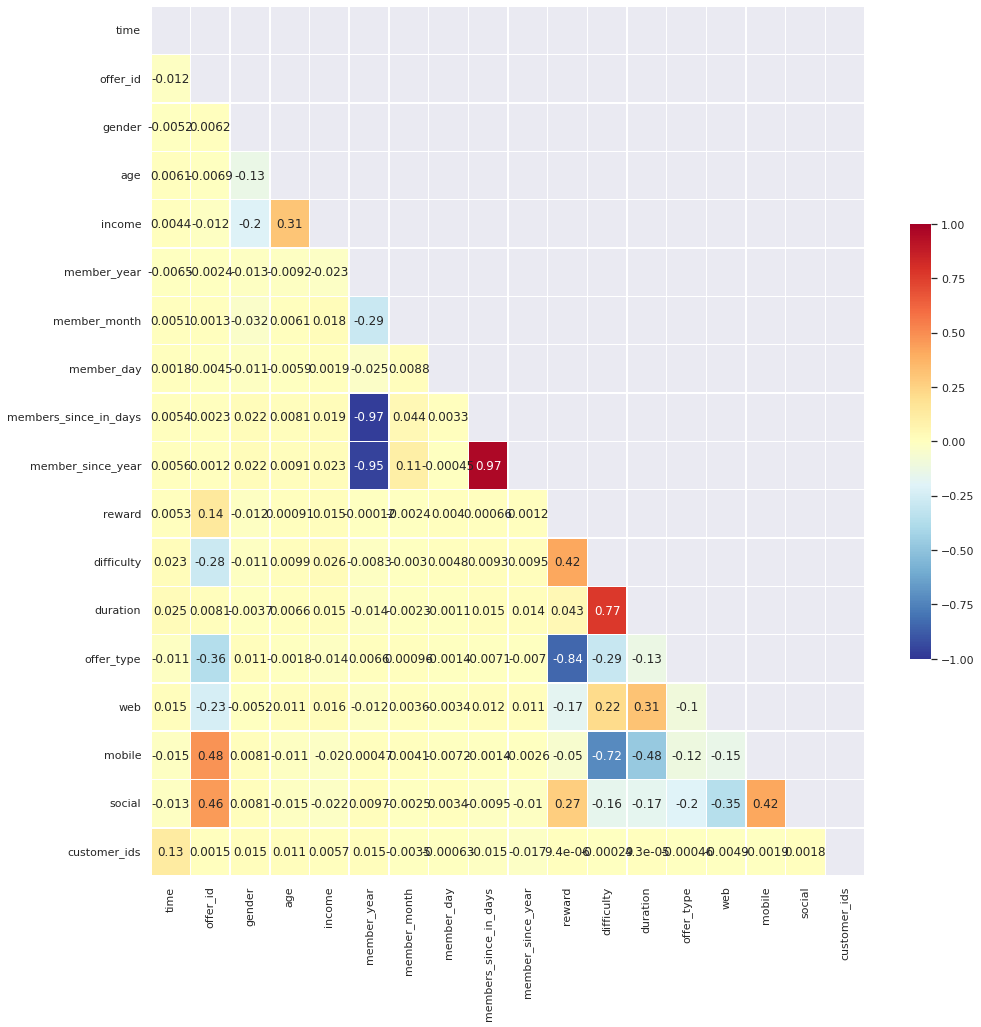

In [20]:
#corr
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
)


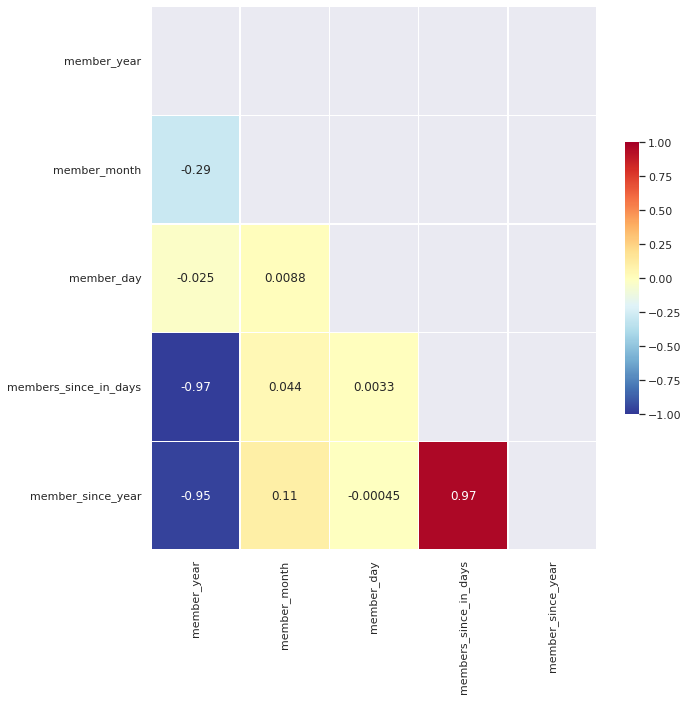

In [21]:
corr = data[['member_year', 'member_month', 'member_day','members_since_in_days' , 'member_since_year']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
)

In [22]:
data.drop(['member_year', 'member_month', 'member_day', 'member_since_year'], axis=1 , inplace = True)

### data check
- email 변수는 제거 (전부 받음)

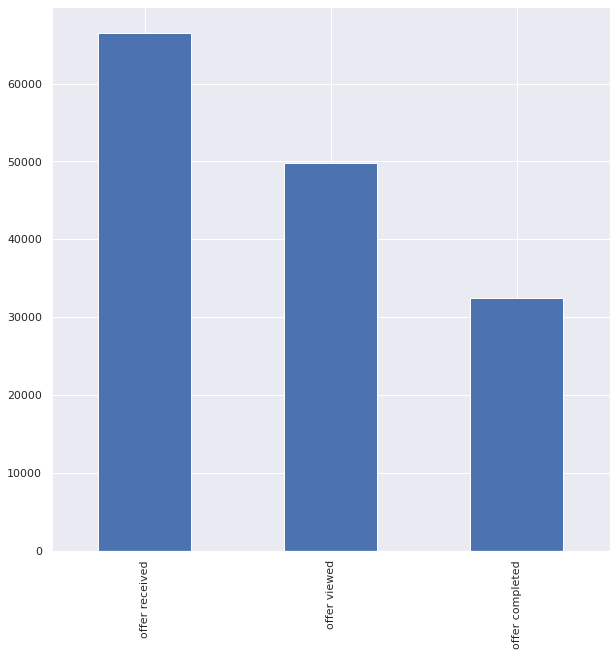

In [23]:
data['event'].value_counts().plot(kind='bar')

In [24]:
# 주어진 data에서 1: informational, 2:discount로 되어 있는데, 거꾸로인듯 함. 
# informational에 completed이 있는것과, discount에 completeted이 전혀 없는 것이 말이 안됨.
print('------BOGO------')
print('recived & BOGO : ' ,len(data[data['offer_type']==0][data['event']=='offer received']))
print('viewed & BOGO : ', len(data[data['offer_type']==0][data['event']=='offer viewed']))
print('completed & BOGO : ' ,len(data[data['offer_type']==0][data['event']=='offer completed']))
print('------discount------')
print('recived & discount : ' ,len(data[data['offer_type']==1][data['event']=='offer received']))
print('viewed & discount : ', len(data[data['offer_type']==1][data['event']=='offer viewed']))
print('completed & discount : ' ,len(data[data['offer_type']==1][data['event']=='offer completed']))
print('------informational------')
print('recived & informational : ' ,len(data[data['offer_type']==2][data['event']=='offer received']))
print('viewed & informtional : ', len(data[data['offer_type']==2][data['event']=='offer viewed']))
print('completed & informational : ' ,len(data[data['offer_type']==2][data['event']=='offer completed']))

------BOGO------
recived & BOGO :  26537
viewed & BOGO :  22039
completed & BOGO :  15258
------discount------
recived & discount :  26664
viewed & discount :  18461
completed & discount :  17186
------informational------
recived & informational :  13300
viewed & informtional :  9360
completed & informational :  0


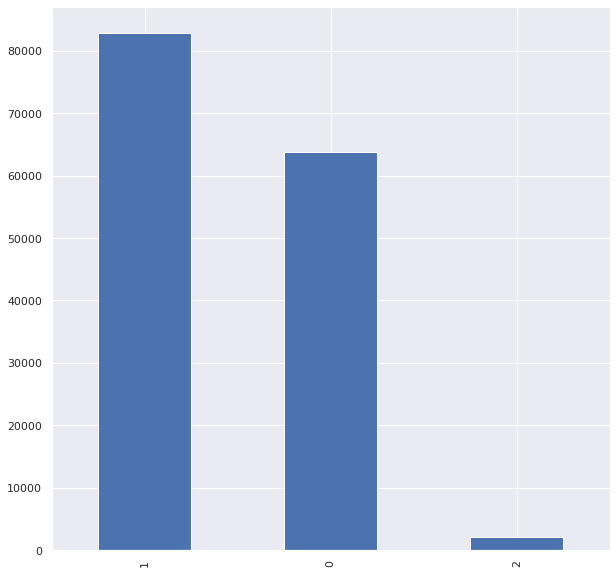

In [25]:
#gender
data['gender'].value_counts().plot(kind='bar')

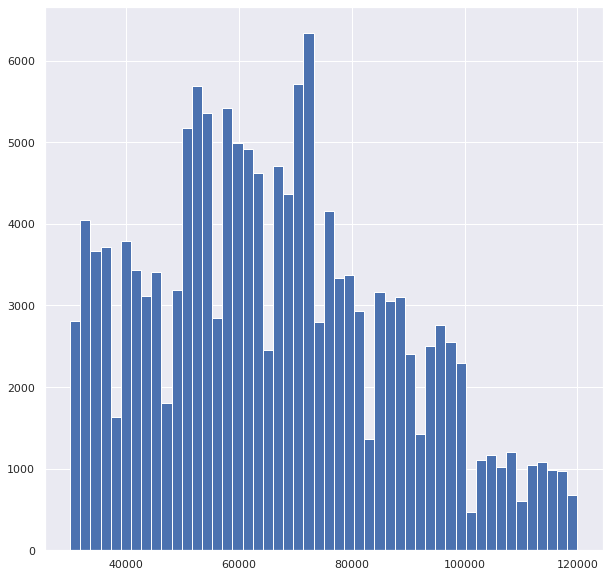

In [26]:
#income
plt.hist(data['income'],bins = 50)
plt.show()

## offer의 랜덤성 분석

In [27]:
offers = []
for i in np.unique(data['customer_ids']):
  offers.append(len(np.unique(data[data['customer_ids']==i]['offer_id'])))


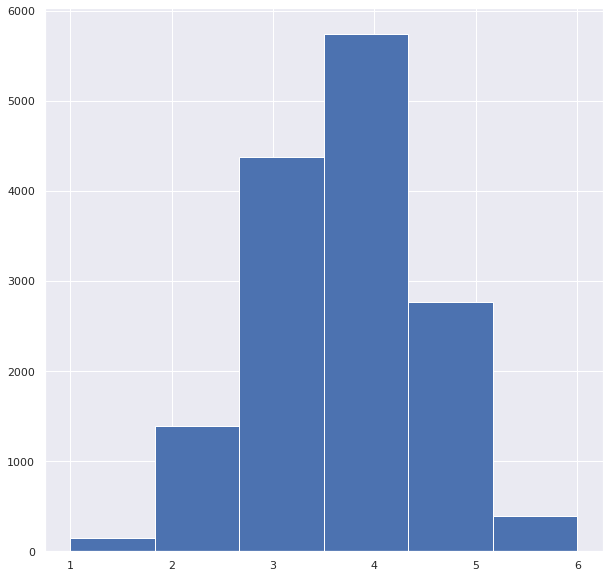

In [28]:
plt.hist(offers,bins = 6)
plt.show()

In [29]:
completed_offers = []
for i in np.unique(data['customer_ids']):
  completed_offers.append(len(data[data['customer_ids']==i][data['event']=='offer completed']))


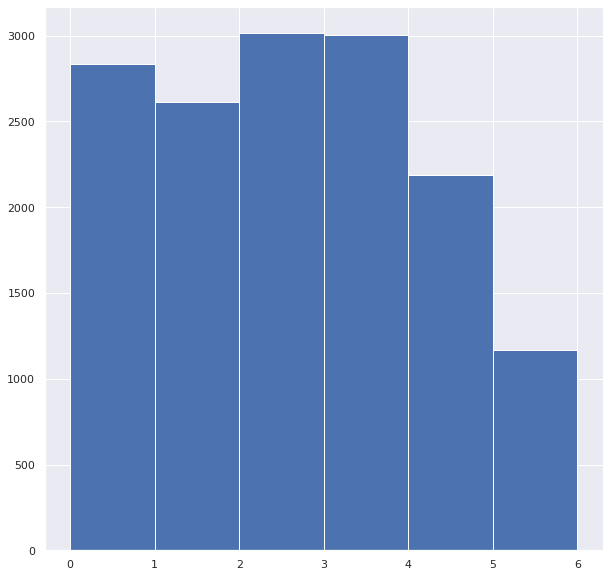

In [30]:
plt.hist(completed_offers,bins = 6)
plt.show()

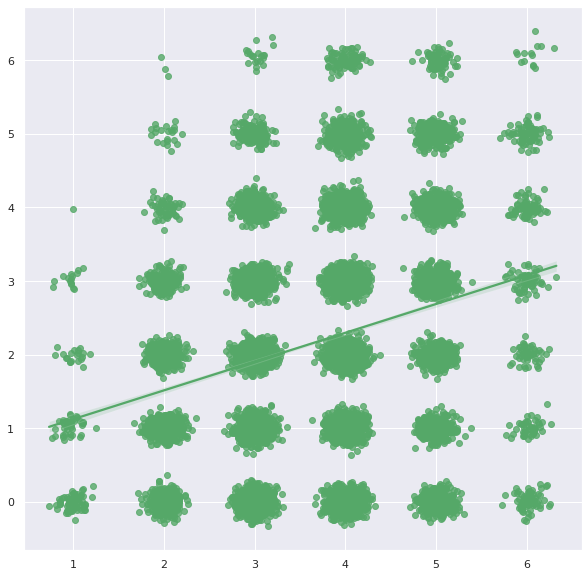

In [31]:
# inputting some noise for graphical interpretation
X = offers + np.random.normal(size = len(offers) ,scale = 0.1)
y=completed_offers+ np.random.normal(size = len(completed_offers), scale = 0.1)
sns.regplot(x=X, y=y, color="g")

둘 사이에 어느정도의 연관성은 있는 듯 하다.

1. 개인과 관련된 변수(성별, 나이, 소득, 멤버십 기간)와 2.offer와 관련된 변수(difficulty, reward, duration, 매체)로 나눌 수 있다.

1. View time을 빠르게 하는 요인
-> offer별 offer_viewed - offer_received를 구해 영향을 많이 주는
-> 매체일 것
-> decisiontree regressor

2. Completion에 영향을 주는 요인
-> reward, difficulty
->decisiontree, logistic, ensemble

3. complete확률이 높은 개인
->decisiontree regressor, ensemble

## 1. View time

In [32]:
taken_times = []
for i in np.unique(data['customer_ids']):
  for j in np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[0][np.argsort(np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[1])]:
    if 'offer viewed' in data[(data.customer_ids ==i) & (data.offer_id ==j) ]['event'].values:
      taken_times.append(data[(data.customer_ids ==i) & (data.offer_id ==j) ]['time'].iloc[1] -data[(data.customer_ids ==i) & (data.offer_id ==j) ]['time'].iloc[0])
    else:
      taken_times.append(600) # view가 없는 경우, 가능한 가장 큰 time 값인 600으로 삽입




In [33]:
data_times = data.drop_duplicates(['customer_ids', 'offer_id'])
data_times = data_times.assign(taken_times=  taken_times)
data_times.drop(['event','time','offer_id', 'customer_ids'],axis=1, inplace = True)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

X = data_times.drop('taken_times',axis=1)
y = data_times['taken_times']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [36]:
r2_tree = DecisionTreeRegressor(random_state=0) 
r2_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [37]:
def plot_feature_importances(model): 
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(X.columns))
    plt.xlabel('attr importances')
    plt.ylabel('attr')
    plt.ylim(-1, n_features)
    plt.show()

In [38]:
def tree_regressor_cv(ccp_alpha, min_impurity_decrease, min_samples_split):

      # 모델 정의
      model = DecisionTreeRegressor(ccp_alpha=ccp_alpha,
                               min_impurity_decrease=min_impurity_decrease,
                               min_samples_split=int(min_samples_split)                           
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)


      mape = mean_absolute_percentage_error(y_test, y_pred)

      # 오차 최적화로 사용할 metric 반환
      return -mape

In [39]:
def randomforest_regressor_cv(max_depth, n_estimators):

      # 모델 정의
      model = RandomForestRegressor(max_depth=int(max_depth),
                                n_estimators=int(n_estimators)                          
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)


      mape = mean_absolute_percentage_error(y_test, y_pred)

      # 오차 최적화로 사용할 metric 반환
      return -mape

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
pbounds = {'max_depth' : (2,30),
           'n_estimators' : (10,300)}
bo_rf=BayesianOptimization(f=randomforest_regressor_cv, pbounds=pbounds, verbose=2, random_state=1 )   
bo_rf.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        | -6.868e+1 |  13.68    |  218.9    |
|  2        | -7.525e+1 |  2.003    |  97.68    |
|  3        | -6.785e+1 |  6.109    |  36.78    |
|  4        | -6.812e+1 |  7.215    |  110.2    |
|  5        | -6.838e+1 |  13.11    |  166.3    |
|  6        | -6.84e+16 |  6.253    |  37.02    |
|  7        | -6.855e+1 |  5.874    |  35.85    |
|  8        | -6.824e+1 |  6.917    |  111.8    |
|  9        | -7.038e+1 |  4.133    |  36.93    |
|  10       | -6.862e+1 |  5.973    |  110.8    |
|  11       | -6.781e+1 |  8.679    |  110.9    |
|  12       | -6.791e+1 |  8.859    |  109.5    |
|  13       | -6.748e+1 |  10.78    |  109.9    |
|  14       | -6.775e+1 |  10.54    |  111.3    |
|  15       | -6.808e+1 |  12.38    |  110.2    |
|  16       | -6.765e+1 |  11.39    |  108.4    |
|  17       | -6.743e+1 |  10.18    |  108.5    |
|  18       | -6.751e+1 |  9.922    |  106.9    |


In [46]:
pbounds = {'ccp_alpha' : (0,0.03),
           'min_impurity_decrease' : (0,0.03),
           'min_samples_split' : (10,1000)}
bo_dr=BayesianOptimization(f=tree_regressor_cv, pbounds=pbounds, verbose=2, random_state=1 )   
bo_dr.maximize(init_points=5, n_iter=200, acq='ei', xi=0.01)

|   iter    |  target   | ccp_alpha | min_im... | min_sa... |
-------------------------------------------------------------
|  1        | -6.944e+1 |  0.01251  |  0.02161  |  10.11    |
|  2        | -6.702e+1 |  0.00907  |  0.004403 |  101.4    |
|  3        | -6.705e+1 |  0.005588 |  0.01037  |  402.8    |
|  4        | -6.814e+1 |  0.01616  |  0.01258  |  688.4    |
|  5        | -6.832e+1 |  0.006134 |  0.02634  |  37.11    |
|  6        | -6.702e+1 |  0.007052 |  0.01071  |  102.0    |
|  7        | -6.705e+1 |  0.002873 |  0.005187 |  364.7    |
|  8        | -6.678e+1 |  0.03     |  0.01566  |  305.7    |
|  9        | -6.7e+16  |  0.000433 |  0.0      |  260.1    |
|  10       | -6.706e+1 |  0.02183  |  0.0288   |  480.6    |
|  11       | -6.761e+1 |  0.0      |  0.0      |  548.2    |
|  12       | -6.851e+1 |  0.0      |  0.03     |  1e+03    |
|  13       | -6.727e+1 |  0.03     |  0.0      |  195.0    |
|  14       | -6.842e+1 |  0.02246  |  0.0      |  835.6    |
|  15   

In [55]:
bayesian_regression_tree = DecisionTreeRegressor(
    ccp_alpha=bo_dr.max['params']['ccp_alpha'],
    min_impurity_decrease=bo_dr.max['params']['min_impurity_decrease'],
    min_samples_split=int(bo_dr.max['params']['min_samples_split'])
    ,max_depth = 3)
bayesian_regression_tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.014701530123872129, max_depth=3,
                      min_impurity_decrease=0.011932189691007632,
                      min_samples_split=53)

In [48]:
bayesian_randomforest_regressor =RandomForestRegressor(max_depth=int(bo_rf.max['params']['max_depth']),
                                n_estimators=int(bo_rf.max['params']['n_estimators'])                          
                                )
bayesian_randomforest_regressor .fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=118)

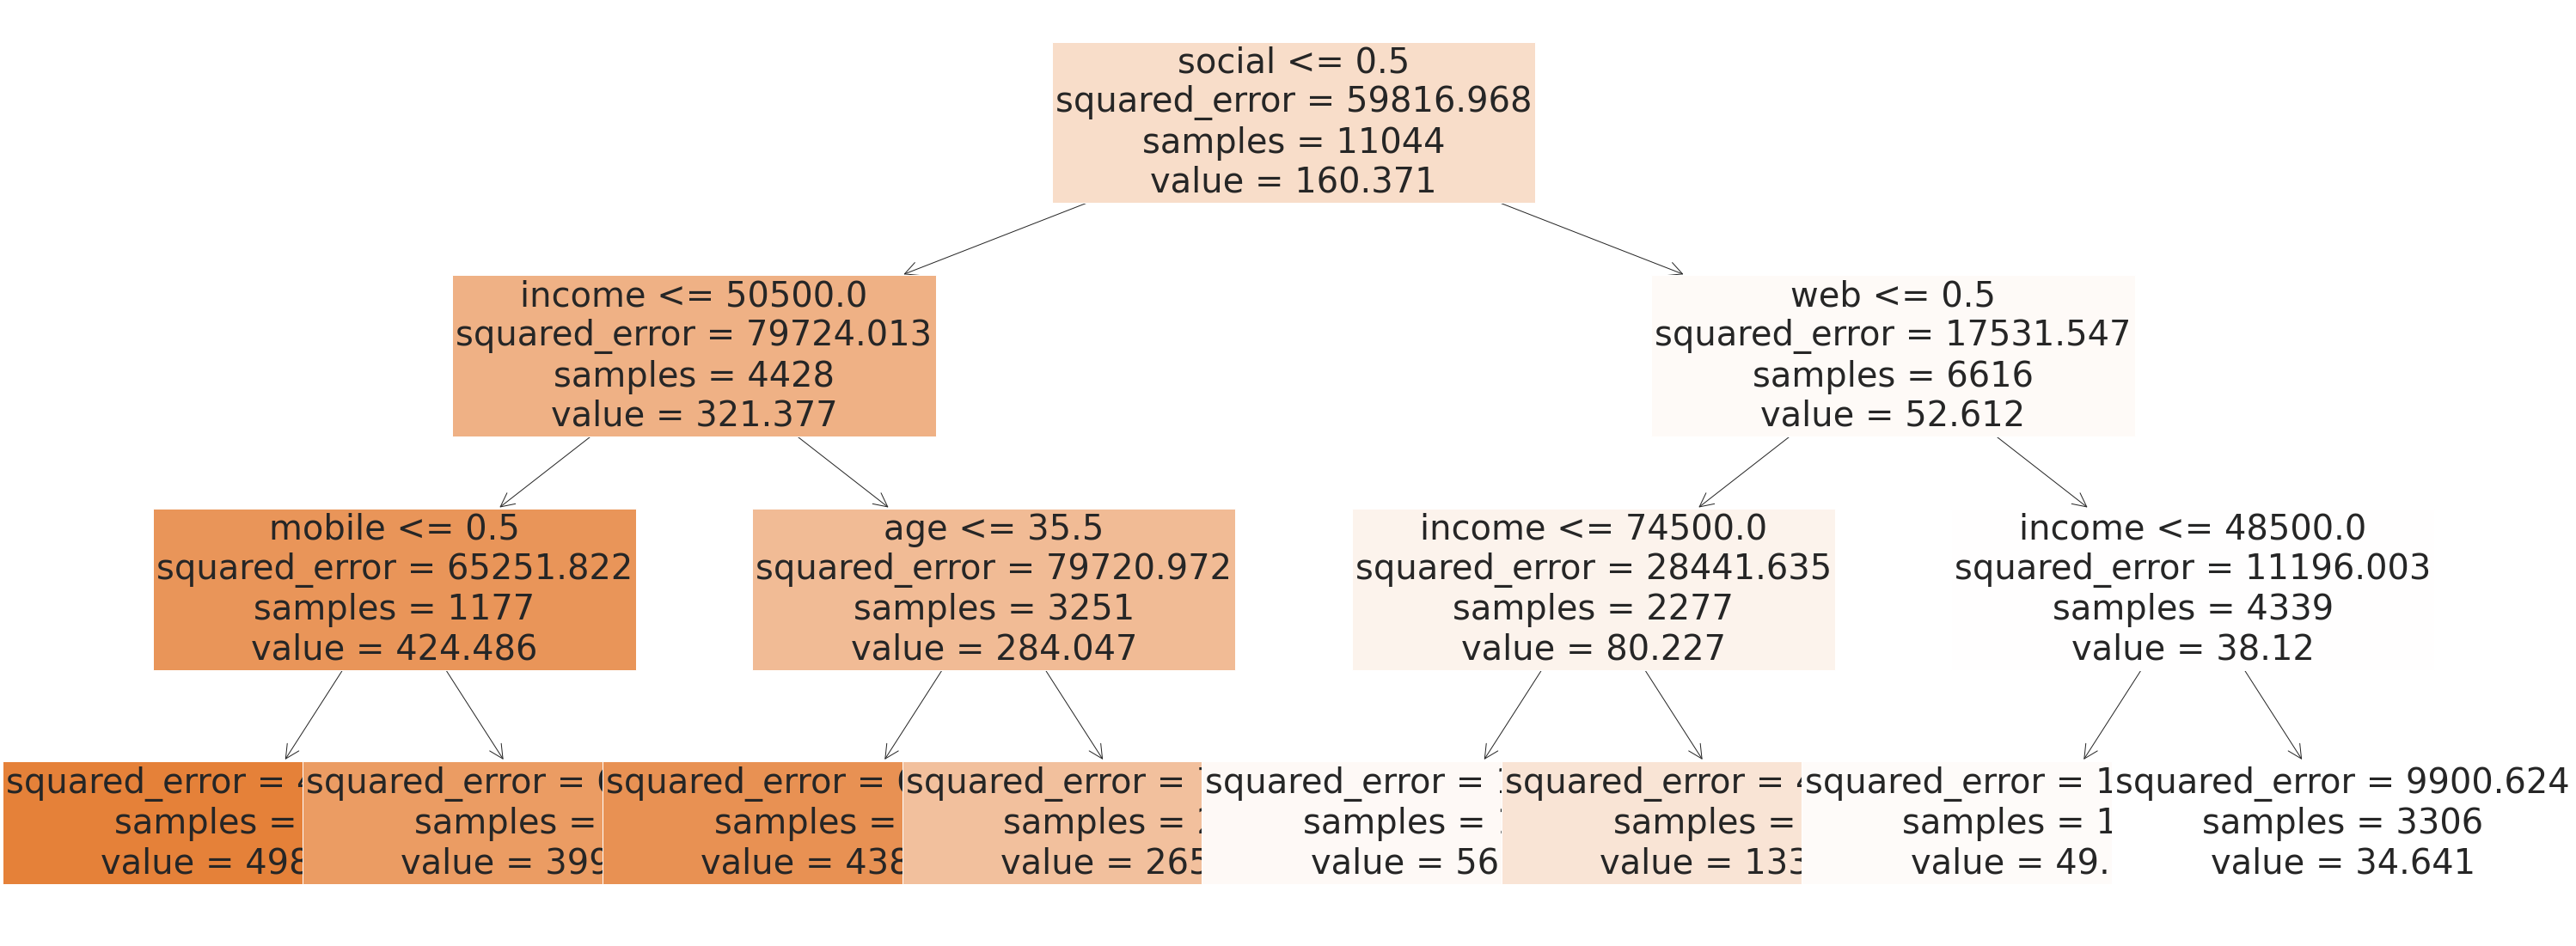

In [60]:
xname = X.columns
plt.figure(figsize=(50,20))
plot_tree(bayesian_regression_tree, feature_names=xname, filled=True, fontsize=40) 
plt.show()

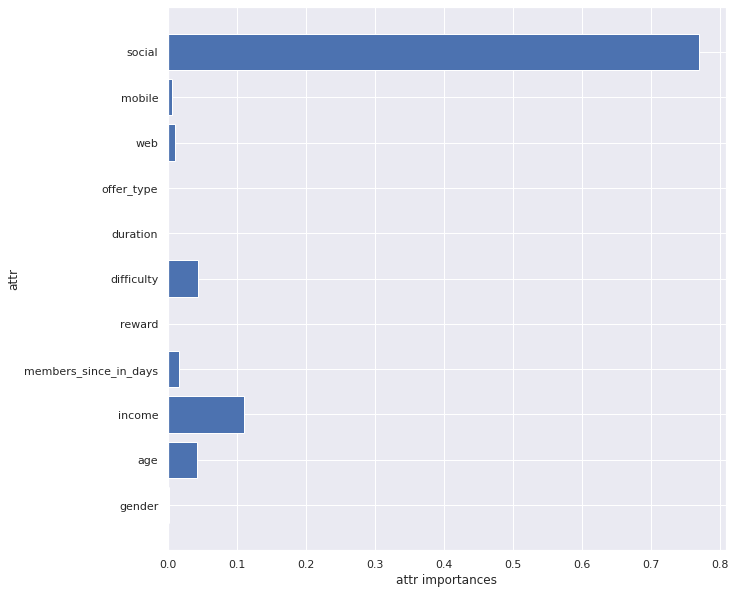

In [52]:
plot_feature_importances(bayesian_regression_tree)

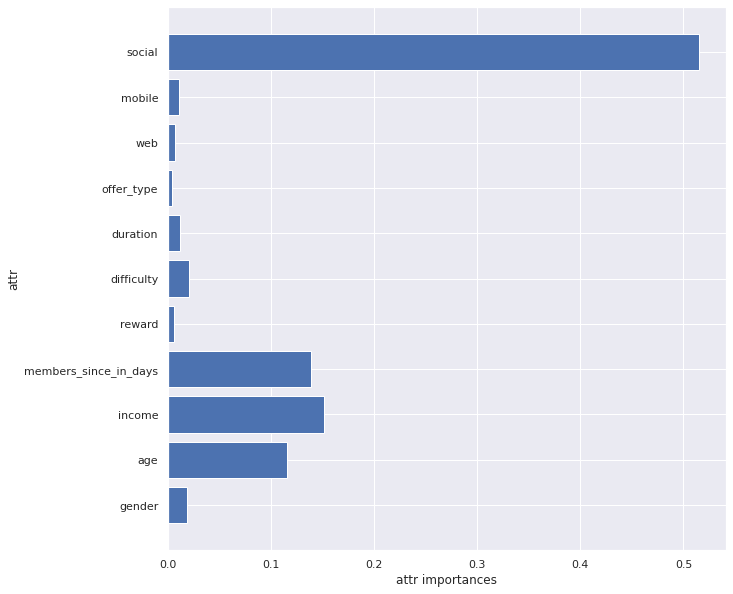

In [53]:
plot_feature_importances(bayesian_randomforest_regressor)

In [54]:
print('Pruned Tree      :',mean_absolute_percentage_error(y_test,bayesian_regression_tree.predict(X_test)))
print('Default Tree     :',mean_absolute_percentage_error(y_test,r2_tree.predict(X_test)))
print('Random Forest    :',mean_absolute_percentage_error(y_test,bayesian_randomforest_regressor.predict(X_test)))

Pruned Tree      : 6.849285953308157e+16
Default Tree     : 7.056087961606516e+16
Random Forest    : 6.752521113458619e+16


## 2. completion

In [ ]:
completions = []
for i in np.unique(data['customer_ids']):
  for j in np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[0][np.argsort(np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[1])]:
    if data[(data.customer_ids ==i) & (data.offer_id ==j)]['offer_type'].iloc[0]==2:
      pass
    else:
      if 'offer completed' in data[(data.customer_ids ==i) & (data.offer_id ==j) ]['event'].values:
        completions.append(1)
      else:
        completions.append(0) 

In [129]:
data_completion = data.drop(data[data['offer_type']==2].index)
data_completion = data_completion.drop_duplicates(['customer_ids', 'offer_id'])
data_completion = data_completion.assign(completions=  completions)
data_completion.drop(['event','time','offer_id', 'customer_ids'],axis=1, inplace = True)

In [66]:
data[37:43][['event', 'offer_id', 'offer_type', 'customer_ids']]

,event,offer_id,offer_type,customer_ids
37,offer received,3,2,4
38,offer received,1,1,4
39,offer viewed,1,1,4
40,offer received,9,1,4
41,offer viewed,9,1,4
42,offer completed,9,1,4


In [128]:
data_completion.loc[[38,40]][[ 'offer_id', 'offer_type', 'customer_ids','completions']]

,offer_id,offer_type,customer_ids,completions
38,1,1,4,0
40,9,1,4,1


In [130]:
from sklearn.tree import DecisionTreeClassifier

X = data_completion.drop('completions',axis=1)
y = data_completion['completions']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
c2_tree = DecisionTreeClassifier(random_state = 0)
c2_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [82]:
def tree_classifier_cv(ccp_alpha, min_impurity_decrease, min_samples_split):

      # 모델 정의
      model = DecisionTreeClassifier(ccp_alpha=ccp_alpha,
                               min_impurity_decrease=min_impurity_decrease,
                               min_samples_split=int(min_samples_split)                           
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)


      accuracy = len(y_pred[(y_pred == y_test)==True])/len(y_pred)

      # 오차 최적화로 사용할 metric 반환
      return accuracy

In [83]:
def randomforest_classifier_cv(max_depth, n_estimators):

      # 모델 정의
      model = RandomForestClassifier(max_depth=int(max_depth),
                                n_estimators=int(n_estimators)                          
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)


      accuracy = len(y_pred[(y_pred == y_test)==True])/len(y_pred)

      # 오차 최적화로 사용할 metric 반환
      return accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pbounds = {'max_depth' : (2,30),
           'n_estimators' : (10,300)}
bo_rc=BayesianOptimization(f=randomforest_classifier_cv, pbounds=pbounds, verbose=2, random_state=1 )   
bo_rc.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

In [ ]:
pbounds = {'ccp_alpha' : (0,0.001),
           'min_impurity_decrease' : (0,0.001),
           'min_samples_split' : (10,1000)}
bo_dc=BayesianOptimization(f=tree_classifier_cv, pbounds=pbounds, verbose=2, random_state=1 )   
bo_dc.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

In [ ]:
bayesian_classification_tree = DecisionTreeClassifier(
    ccp_alpha=bo_dr.max['params']['ccp_alpha'],
    min_impurity_decrease=bo_dr.max['params']['min_impurity_decrease'],
    min_samples_split=int(bo_dr.max['params']['min_samples_split']))
bayesian_classification_tree.fit(X_train,y_train)

In [116]:
bayesian_classification_tree = DecisionTreeClassifier(
    ccp_alpha=bo_dc.max['params']['ccp_alpha'],
    min_impurity_decrease=bo_dc.max['params']['min_impurity_decrease'],
    min_samples_split=int(bo_dc.max['params']['min_samples_split']))
bayesian_classification_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00023004184851319997,
                       min_impurity_decrease=6.478681753403282e-05,
                       min_samples_split=706)

In [112]:
bayesian_randomforest_classification =RandomForestClassifier(max_depth=int(bo_rc.max['params']['max_depth']),
                                n_estimators=int(bo_rc.max['params']['n_estimators'])                          
                                )
bayesian_randomforest_classification.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=245)

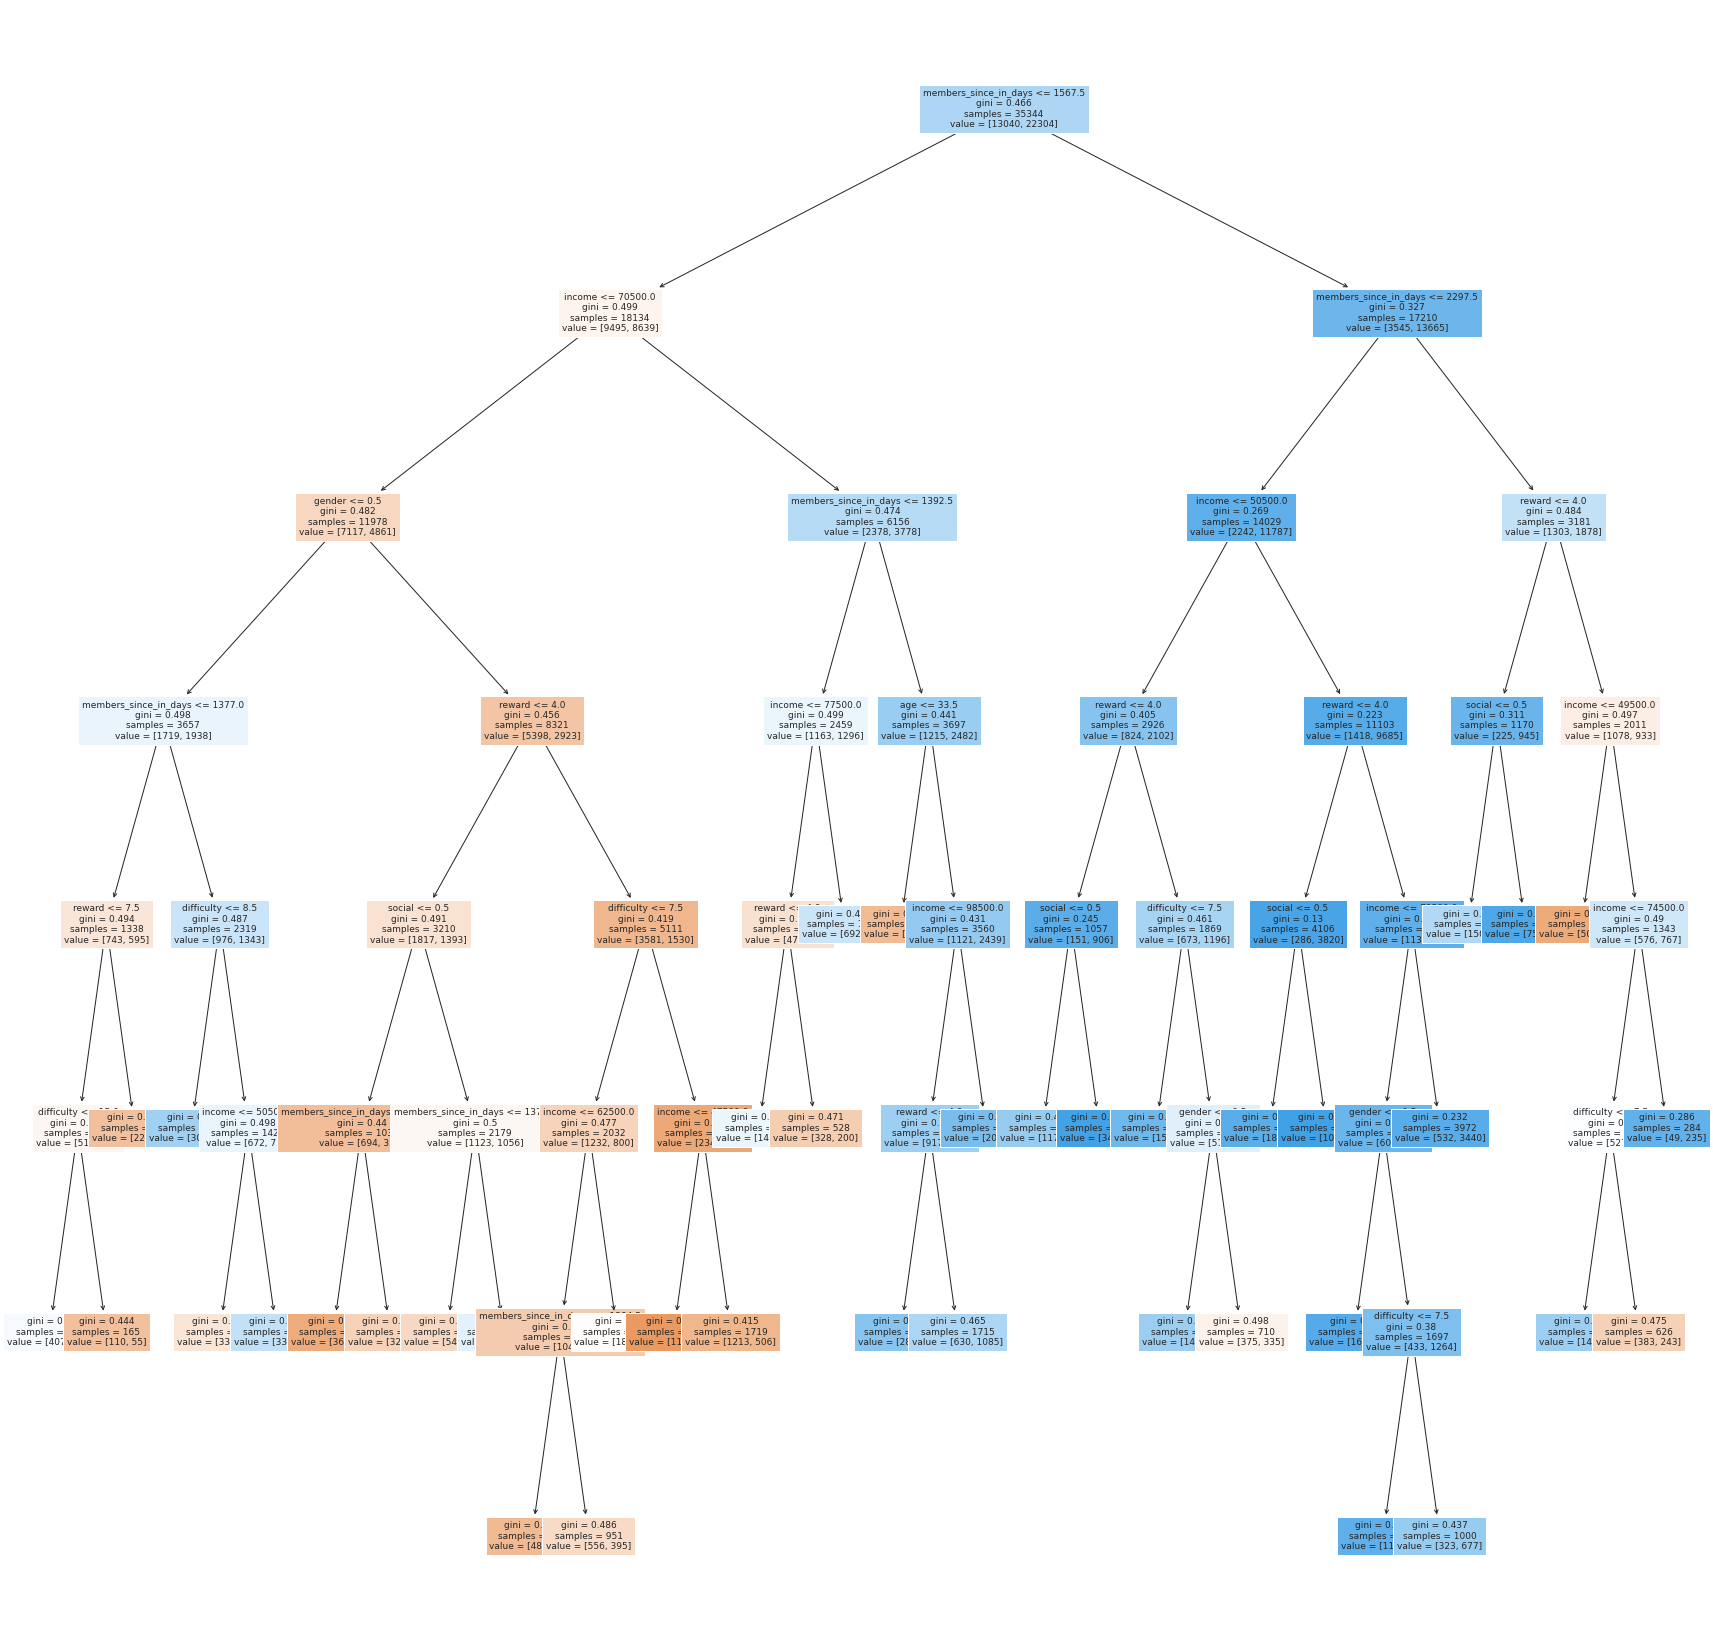

In [146]:
xname = X.columns
plt.figure(figsize=(30,30))
plot_tree(bayesian_classification_tree, feature_names=xname, filled=True, fontsize=9) 
plt.show()

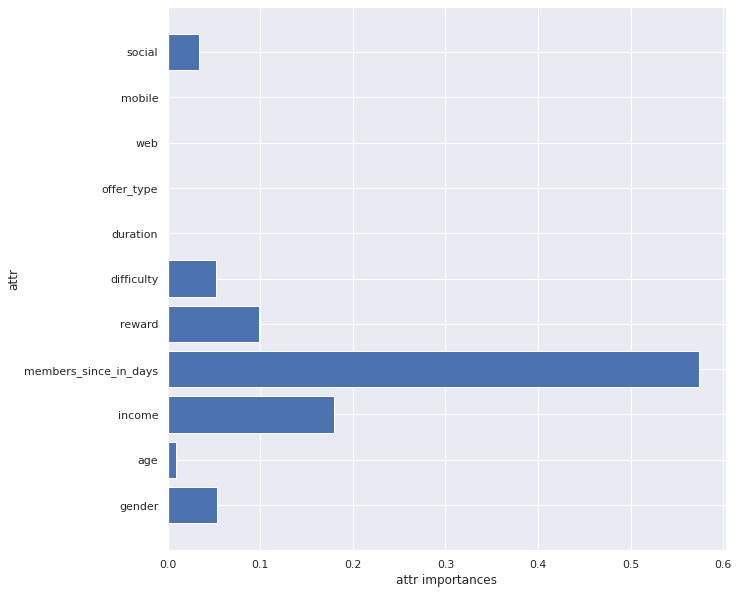

In [117]:
plot_feature_importances(bayesian_classification_tree)

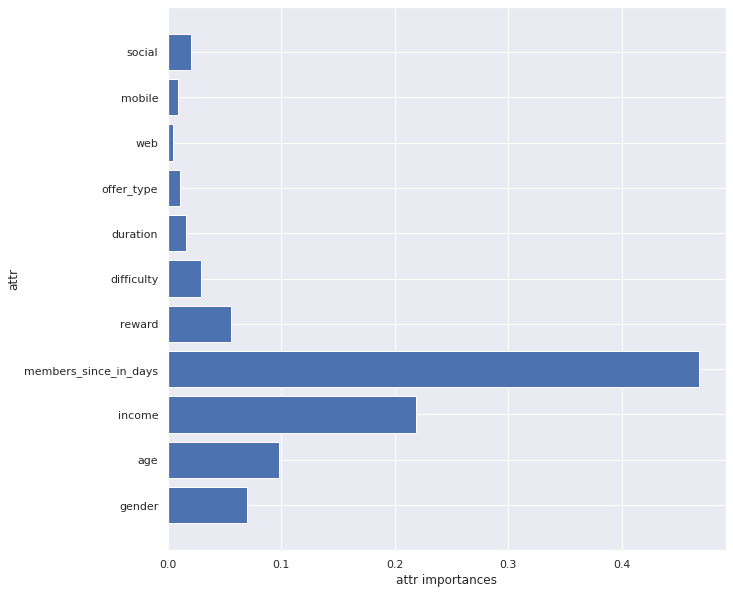

In [118]:
plot_feature_importances(bayesian_randomforest_classification)

In [138]:
from sklearn.linear_model import LogisticRegression
c_logit = LogisticRegression(random_state=0, max_iter = 1000)
c_logit.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
roc_tree=RocCurveDisplay.from_estimator(bayesian_classification_tree, X_test, y_test)
RocCurveDisplay.from_estimator(c_logit, X_test, y_test, ax = roc_tree.ax_)
RocCurveDisplay.from_estimator(c2_tree, X_test, y_test, ax = roc_tree.ax_)
RocCurveDisplay.from_estimator(bayesian_randomforest_classification, X_test, y_test, ax = roc_tree.ax_)
plt.title("ROC curve comparison")
plt.show()

In [145]:
print('default tree AUC: ', roc_auc_score(y_test,c2_tree.predict(X_test) ))
print('pruned tree AUC:' , roc_auc_score(y_test,bayesian_classification_tree.predict(X_test) ))
print('randomforest AUC:' , roc_auc_score(y_test,bayesian_randomforest_classification.predict(X_test) ))
print('logistic  AUC: ', roc_auc_score(y_test,c_logit.predict(X_test) ))

default tree AUC:  0.6475594426291207
pruned tree AUC: 0.6812089091782296
randomforest AUC: 0.6899915291460472
logistic  AUC:  0.5


In [100]:
import statsmodels.api as sm 
X_train_scaled_constant = sm.add_constant(X_train)
model2 = sm.Logit(y_train,X_train_scaled_constant).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.578186
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            completions   No. Observations:                35344
Model:                          Logit   Df Residuals:                    35332
Method:                           MLE   Df Model:                           11
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                  0.1218
Time:                        16:22:15   Log-Likelihood:                -20435.
converged:                       True   LL-Null:                       -23270.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.9468      0.217    -13.603      0.000      -3.371      -2.522
gender                   -0.5096      0.024    -21.305      0.000      -0.557      -0.463
age                       0.0040      0.001      5.564      0.000       0.003       0.005
income                 2.291e-05   6.22e-07     36.834      0.000    2.17e-05    2.41e-05
members_since_in_days     0.0012   3.11e-05     39.561      0.000       0.001       0.001
reward                    0.0099      0.017      0.595      0.552      -0.023       0.043
difficulty               -0.1380      0.013    -10.774      0.000      -0.163      -0.113
duration                  0.1597      0.014     11.543      0.000       0.133       0.187
offer_type                0.5412      0.093      5.789      0.000       0.358       0.724
web                       0.1124      0.053      2.102      0.036       0.008       0.217
mobile                   -0.4367      0.107     -4.094      0.000      -0.646      -0.228
social                    0.3253      0.035      9.310      0.000       0.257       0.394
=========================================================================================
"""

In [139]:
import statsmodels.api as sm 
X_train_scaled_constant = sm.add_constant(X_train_scaled)
model2 = sm.Logit(y_train,X_train_scaled_constant).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.578186
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            completions   No. Observations:                35344
Model:                          Logit   Df Residuals:                    35332
Method:                           MLE   Df Model:                           11
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                  0.1218
Time:                        17:25:43   Log-Likelihood:                -20435.
converged:                       True   LL-Null:                       -23270.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6471      0.012     52.388      0.000       0.623       0.671
x1            -0.2630      0.012    -21.305      0.000      -0.287      -0.239
x2             0.0689      0.012      5.564      0.000       0.045       0.093
x3             0.4966      0.013     36.834      0.000       0.470       0.523
x4             0.5154      0.013     39.561      0.000       0.490       0.541
x5             0.0296      0.050      0.595      0.552      -0.068       0.127
x6            -0.6147      0.057    -10.774      0.000      -0.726      -0.503
x7             0.2855      0.025     11.543      0.000       0.237       0.334
x8             0.2706      0.047      5.789      0.000       0.179       0.362
x9             0.0374      0.018      2.102      0.036       0.003       0.072
x10           -0.1450      0.035     -4.094      0.000      -0.214      -0.076
x11            0.1575      0.017      9.310      0.000       0.124       0.191
==============================================================================
"""

## 3.

In [ ]:
individual_score = []
for i in np.unique(data['customer_ids']):
  score = 0 
  for j in np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[0][np.argsort(np.unique(data[data.customer_ids ==i  ].offer_id,return_index=True)[1])]:
    if 'offer completed' in data[(data.customer_ids ==i) & (data.offer_id ==j) ]['event'].values:
      score+=0.8
    elif 'offer viewed' in data[(data.customer_ids ==i) & (data.offer_id ==j) ]['event'].values:
      score+=0.2
  individual_score.append(score)

In [ ]:
data_individual = data.drop(['event', 'time','offer_id','reward','difficulty','duration','offer_type','web','mobile','social'], axis=1)
data_individual = data_individual.drop_duplicates(['customer_ids'])
data_individual = data_individual.assign(individual_score=  individual_score)

In [ ]:

data_individual